In [4]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt    
from matplotlib.patches import Rectangle
from astropy.wcs import WCS                 
from astropy import units as u  
import pylab
import numpy as np
from spectral_cube import SpectralCube     
import pyspeckit as psk
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# Finds center of cloud c

In [5]:
path="B.Dust_Ridge_sci.spw25_27_29_31.cont.I.tt0.pbcor.fits"
header=fits.getheader(path)
w1=WCS(header)
w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)

#finds the pixel positions for the RA and dec
#find RA DEC of x,y,z
core_coords=w1.pixel_to_world(175,166)
print(core_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (266.58818356, -28.59536026)>


# Plots Spectrum

(array(144.), array(136.5882353))
Noise lower: 109.71717526238828 GHz
Noise upper: 109.72022734558759 GHz
Width: 0.003052083199307276 GHz
sigma: 0.06024275697847313 K
3 sigma: 0.18072827093541938 K


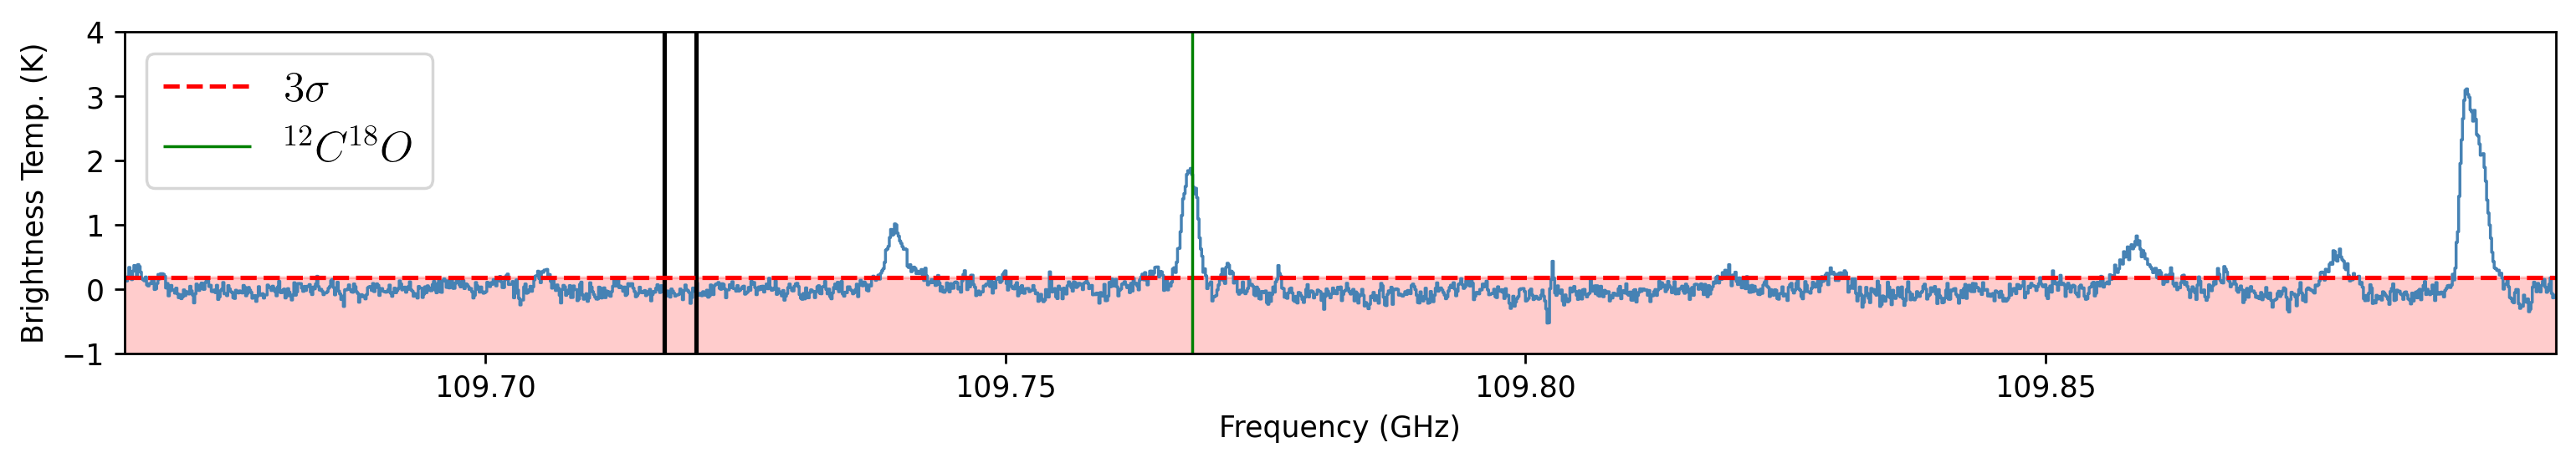

In [6]:

#reads in file
path="A.Dust_Ridge_12C18O.cube.I.pbcor.fits"
#makes figure
fig1=pylab.figure(1,figsize=(15,2),dpi=250)



#find the corresponding pixel positions for those coords in new image
header=fits.getheader(path)
w2=WCS(header)
image_coords=core_coords.to_pixel(w2,0,mode="wcs")
print(image_coords)

#plots spectrum
sc=SpectralCube.read(path)
sc.allow_huge_operations=True 
sc_Ghz=sc.with_spectral_unit(u.GHz)
sc_Ghz=sc_Ghz.to(u.K)
freq,Dec,Ra = sc_Ghz.world[:,0,0] 
subcube=sc_Ghz.hdu.data[:,int(image_coords[0])-5:int(image_coords[0])+5,int(image_coords[1])-5:int(image_coords[1])+5]
spectrum = np.average(subcube,axis=(1,2)) 
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
pylab.xlabel("Frequency (GHz)", fontsize=10)
    
pylab.ylabel('Brightness Temp. (K)',fontsize=10)
pylab.ylim(-1,4)

plt.rcParams['text.usetex'] = True

###Noise###
Noise_upper=450
Noise_lower=425
width=freq[Noise_upper]-freq[Noise_lower]
print(f"Noise lower: {freq[Noise_lower]}")
print(f"Noise upper: {freq[Noise_upper]}")
print(f"Width: {width}")
#lower line
pylab.vlines(freq[Noise_lower].value,-1,4,colors="black")
#upper line
pylab.vlines(freq[Noise_upper].value,-1,4,colors="black")
#calculate 3 sigma
sigma=np.std(spectrum[Noise_lower:Noise_upper])
three_sigma=3*sigma
#three_sigma_Jy=three_sigma.to(u.jansky)
print(f"sigma: {sigma} K")
print(f"3 sigma: {three_sigma} K")
#print(f"3 sigma: {three_sigma_Jy} Jy")
pylab.hlines(three_sigma,freq[0].value,freq[1915].value,colors="red",label =r'$3 \sigma$',ls="--" )

pylab.xlim(freq[0].value,freq[1915].value)
ax1.fill_between(freq.value,three_sigma, -2, alpha = 0.2, color= 'red' )


#12C18O
pylab.vlines(109.768,-2,7,colors="green",linewidth=1,label=r"${}^{12}C^{18}O$")

plt.legend(fontsize=15)
#plt.title()
plt.savefig("12C18O.pdf")



# Sigma Noise

In [4]:
sigma_pop=np.std(spectrum[0:550])
sigma_sample=np.std(spectrum[0:550], ddof=1)
print(sigma_sample)
print(sigma_pop)
print(freq[0],freq[550])

0.10312882485086879
0.10303502871972957
109.665289848 GHz 109.73243567838483 GHz


# HNCO line ID

Param #0   AMPLITUDE0 =      3.06015 +/-       0.0326286 
Param #1       SHIFT0 =      109.891 +/-     1.26844e-05 
Param #2       WIDTH0 =   0.00103026 +/-     1.26844e-05   Range:   [0,inf)


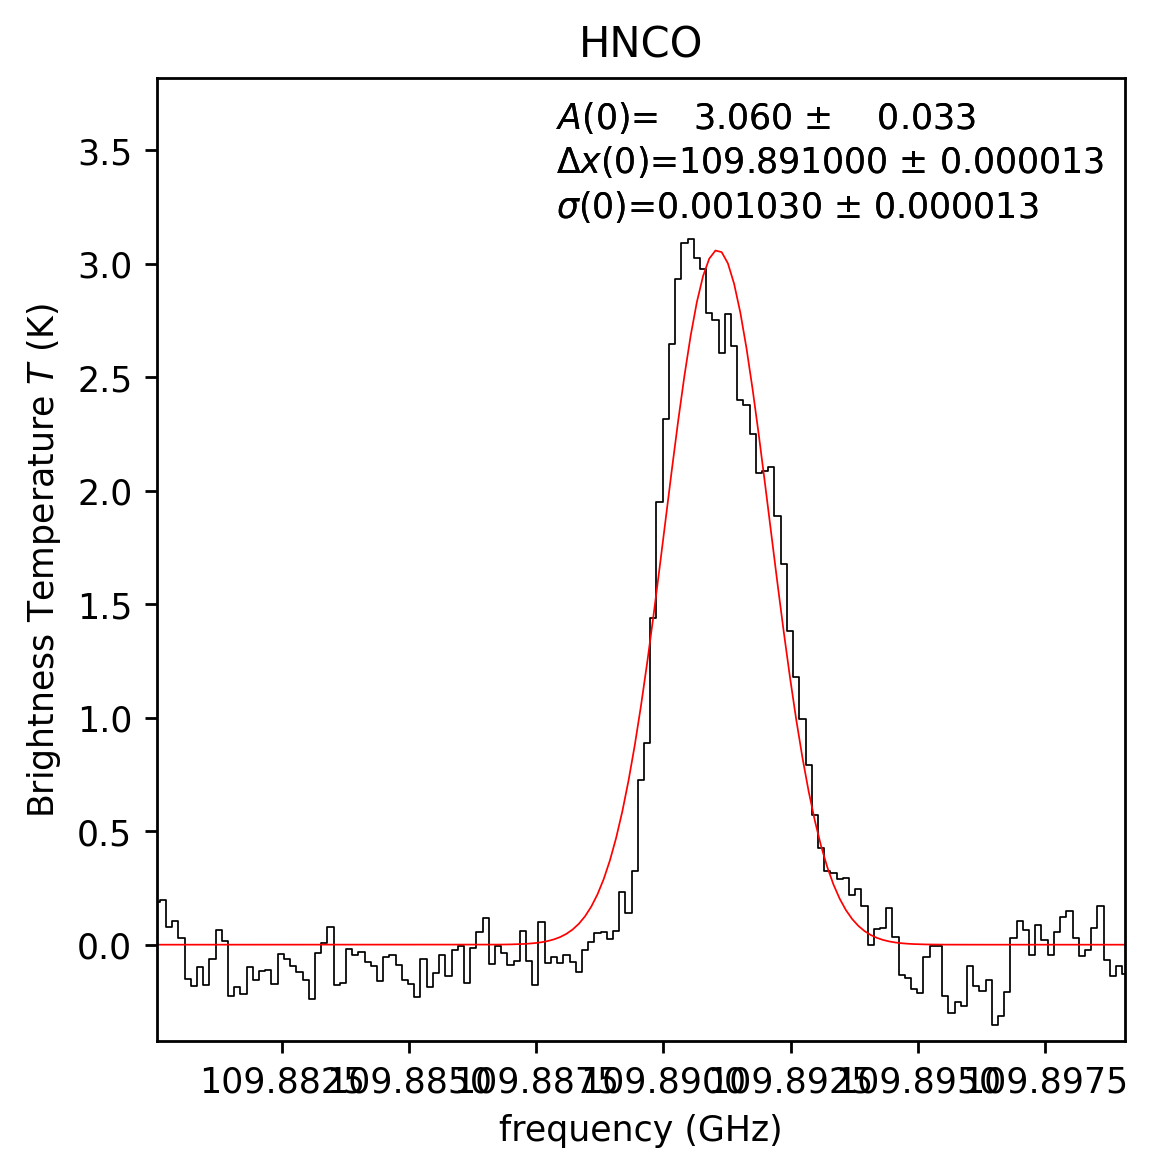

In [16]:
#zooms in on major intensity spike (assumed to be 12CO)
zoom = np.where((freq.value>109.88)*(freq.value<109.9))

#zooms in on the spectrum we found in the last code block
zoom_12C180=spectrum[zoom]

#zooms in on the frequency's in this zoomed in region
zoom_freq = freq[zoom]


error = np.zeros(np.size(zoom))
wheremeas = np.where((zoom_freq.value>109.89)*(zoom_freq.value<109.9))
meas = np.std(spectrum[0:550])
error = error + meas

sp = psk.Spectrum(data=zoom_12C180,xarr=zoom_freq,error=error,unit='K')
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1),title="HNCO")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('12C180gaussianprofileplot.png')
print(sp.specfit.parinfo)

# CO Identification

Param #0   AMPLITUDE0 =      1.88354 +/-       0.0384509 
Param #1       SHIFT0 =      109.768 +/-     1.74876e-05 
Param #2       WIDTH0 =   0.00074187 +/-     1.74876e-05   Range:   [0,inf)


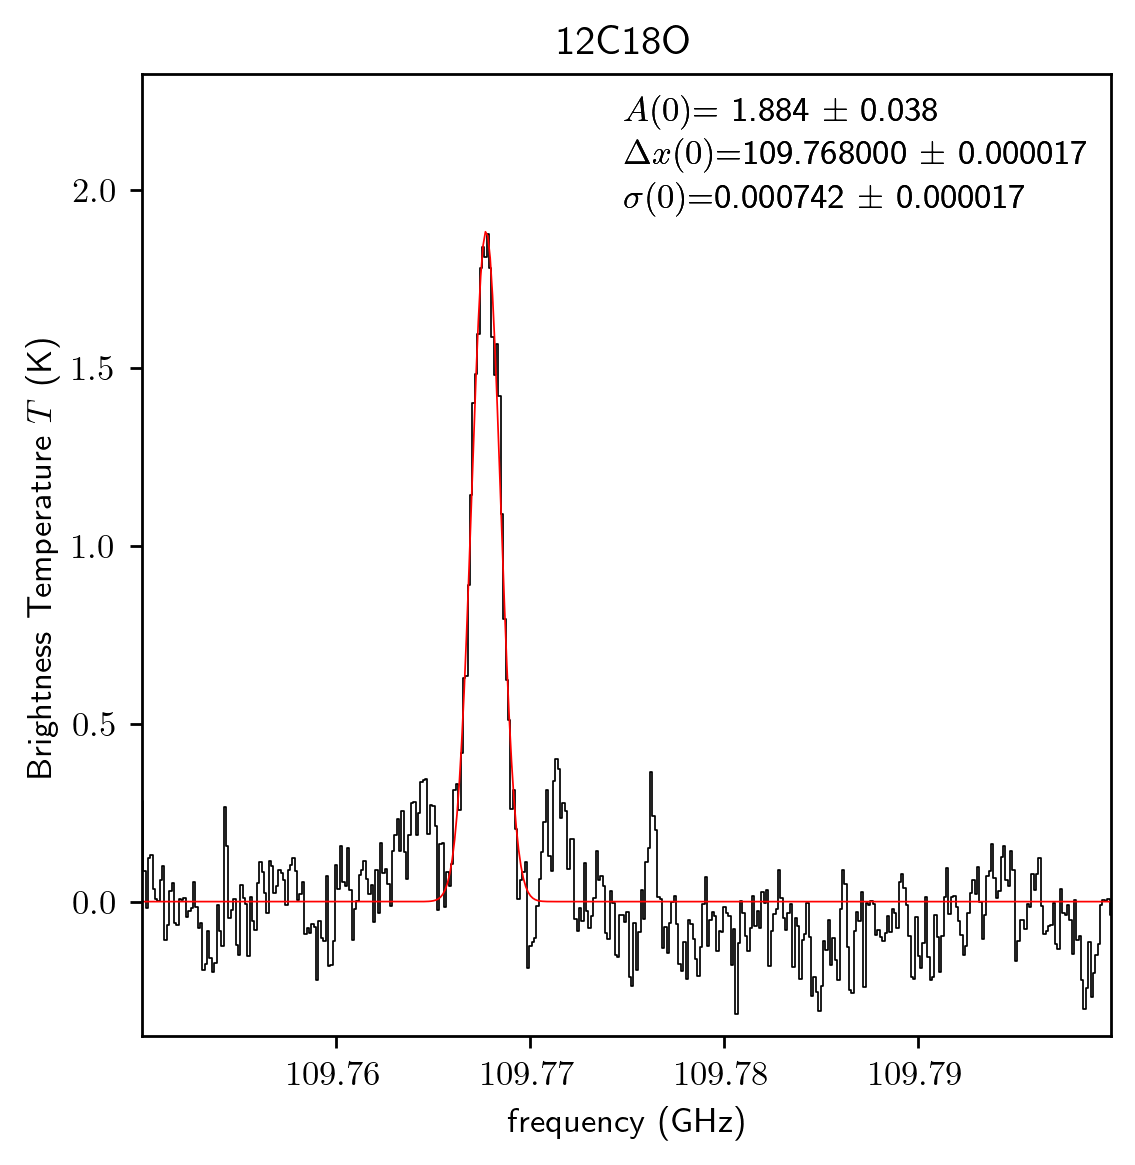

In [4]:
#zooms in on major intensity spike (assumed to be 12CO)
zoom = np.where((freq.value>109.75)*(freq.value<109.8))

#zooms in on the spectrum we found in the last code block
zoom_12C180=spectrum[zoom]

#zooms in on the frequency's in this zoomed in region
zoom_freq = freq[zoom]


error = np.zeros(np.size(zoom))
wheremeas = np.where((zoom_freq.value>109.89)*(zoom_freq.value<109.9))
meas = np.std(spectrum[0:550])
error = error + meas

sp = psk.Spectrum(data=zoom_12C180,xarr=zoom_freq,error=error,unit='K')
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1),title="12C18O")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('12C180gaussianprofileplot.pdf')
print(sp.specfit.parinfo)

# line ID 

Param #0   AMPLITUDE0 =      3.06015 +/-       0.0190774 
Param #1       SHIFT0 =      109.891 +/-     7.41636e-06 
Param #2       WIDTH0 =   0.00103026 +/-     7.41636e-06   Range:   [0,inf)


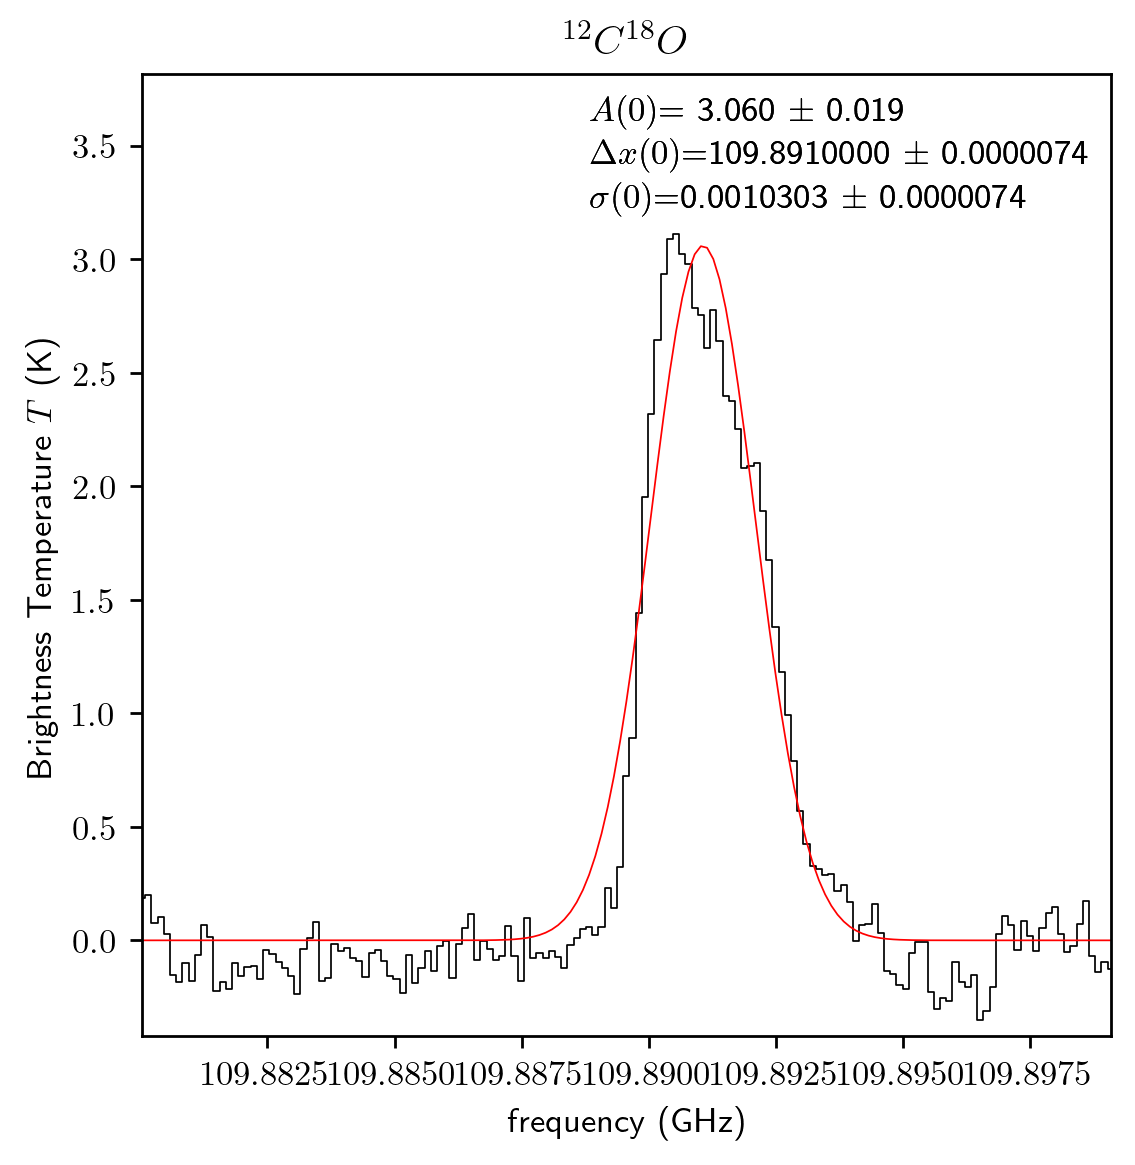

In [17]:
import pyspeckit
#Creates regions zoomed around feature
zoom = np.where((freq.value>109.88)*(freq.value<111))
zoom_spectrum=spectrum[zoom]
zoom_freq = freq[zoom]

#Calculates the error 
error = np.zeros(np.size(zoom))
meas = sigma #uses sigma calc from previous block
error = error + meas

#plots the gaussian fit
sp = pyspeckit.Spectrum(data=zoom_spectrum,xarr=zoom_freq,error=error,unit='K')
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1),title=r"${}^{12}C^{18}O$")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('12C18O.brightest.pdf')
sp.plotter.savefig('12C18O.brightest.png')
print(sp.specfit.parinfo)